In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
import h5py
import os
import itertools
from scipy.special import kn
from utils import *

In [2]:
n_cfgs = 5
n_ops = 5
n_files = [52, 53, 33, 42, 47]
configs = ['24I/ml_0p01', '24I/ml_0p005', '32I/ml0p008', '32I/ml0p006', '32I/ml0p004']
labels = ['O1', 'O2', 'O3', 'O1p', 'O2p']
colors = ['r', 'g', 'b', 'c', 'y']

# Lattice spacing and physical constants from PDG. Pairs are (value, error), and everything should be in GeV.
ainv_0 = np.array([[1.784, 0.005], [1.784, 0.005], [2.382, 0.008], [2.382, 0.008], [2.382, 0.008]], dtype = np.float64)
mpi_0 = (0.13957039, 1.8e-7)        # (value, error) in GeV
fpi_0 = (0.1302, 1.2e-3)

# Generate fake ensembles
ainv_ens = [gen_fake_ensemble(ainv_0[i], n_files[i]) for i in range(n_cfgs)]
mpi_0_ens = [gen_fake_ensemble(mpi_0, n_files[i]) for i in range(n_cfgs)]
fpi_0_ens = [gen_fake_ensemble(fpi_0, n_files[i]) for i in range(n_cfgs)]

In [3]:
# Read in data input. Restore units to mpi, fpi, and the matrix elements
mat_elems = []        # mat_elemems[cfg_idx, file_idx, op_idx]... store in list because it can have different dims
mpi, fpi, Lchi_sq, eps_sq = [], [], [], []
for cfg_idx, config in enumerate(configs):
    mat_elems.append(np.zeros((n_files[cfg_idx], n_ops), dtype = np.float64))
    path = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/fits/' + config + '/fit_params.h5'
    f = h5py.File(path, 'r')
    a4_mat_elem = f['fits'][()]
    for i in range(n_ops):
        # TODO figure out this factor, David just throws it into the middle of his code and it changes the results
        mult_factor = 1 / 16 if i == 0 or 3 else 1 / 8    # random multiplication factor in David's code???
        mat_elems[cfg_idx][:, i] = a4_mat_elem[:, i] * (ainv_ens[cfg_idx][:] ** 4) * mult_factor    # restore units
    # mat_elems.append(f['fits'][()])
    f.close()
    mpi_path = '/Users/theoares/Pi_Pi/' + config + '/fits/results/fit_params/mpi_jacks.dat'
    a_mpi = np.genfromtxt(mpi_path)
    fpi_path = '/Users/theoares/Pi_Pi/' + config + '/fits/results/fit_params/fpi_jacks.dat'
    a_fpi = np.genfromtxt(fpi_path)
    if config == '32I/ml0p004':
        err_idx = int((840 - 520) / 20)
        a_mpi = np.delete(a_mpi, err_idx)
        a_fpi = np.delete(a_fpi, err_idx)
    mpi_tmp = a_mpi * ainv_ens[cfg_idx]
    fpi_tmp = a_fpi * ainv_ens[cfg_idx]
    # Lchi_sq_tmp = 8 * (np.pi ** 2) * (fpi_tmp ** 2)
    Lchi_sq_tmp = 8 * (np.pi ** 2) * (fpi_0_ens[cfg_idx] ** 2)
    eps_sq_tmp = (mpi_tmp ** 2) / (Lchi_sq_tmp)
    mpi.append(mpi_tmp)
    fpi.append(fpi_tmp)
    Lchi_sq.append(Lchi_sq_tmp)
    eps_sq.append(eps_sq_tmp)

In [4]:
# generate information in tables 2 and 3
print('Running statistics with physical units')
mat_boot_μ, mat_boot_σ = np.zeros((n_cfgs, n_ops), dtype = np.float64), np.zeros((n_cfgs, n_ops), dtype = np.float64)
mpi_boot_μ, mpi_boot_σ = np.zeros((n_cfgs), dtype = np.float64), np.zeros((n_cfgs), dtype = np.float64)
fpi_boot_μ, fpi_boot_σ = np.zeros((n_cfgs), dtype = np.float64), np.zeros((n_cfgs), dtype = np.float64)
eps_boot_μ, eps_boot_σ = np.zeros((n_cfgs), dtype = np.float64), np.zeros((n_cfgs), dtype = np.float64)
for cfg_idx in range(n_cfgs):
    print(configs[cfg_idx])
    mat_boot = bootstrap(mat_elems[cfg_idx], data_type = np.float64)
    mpi_boot = bootstrap(mpi[cfg_idx], data_type = np.float64)
    fpi_boot = bootstrap(fpi[cfg_idx], data_type = np.float64)
    eps_boot = bootstrap(eps_sq[cfg_idx], data_type = np.float64)
    mat_boot_μ[cfg_idx, :], mat_boot_σ[cfg_idx, :] = np.mean(mat_boot, axis = 0), np.std(mat_boot, axis = 0)
    mpi_boot_μ[cfg_idx], mpi_boot_σ[cfg_idx] = np.mean(mpi_boot, axis = 0), np.std(mpi_boot, axis = 0)
    fpi_boot_μ[cfg_idx], fpi_boot_σ[cfg_idx] = np.mean(fpi_boot, axis = 0), np.std(fpi_boot, axis = 0)
    eps_boot_μ[cfg_idx], eps_boot_σ[cfg_idx] = np.mean(eps_boot, axis = 0), np.std(eps_boot, axis = 0)
    print('m_pi: ' + str(mpi_boot_μ[cfg_idx]) + ' \pm ' + str(mpi_boot_σ[cfg_idx]))
    print('f_pi: ' + str(fpi_boot_μ[cfg_idx]) + ' \pm ' + str(fpi_boot_σ[cfg_idx]))
    print('epsilon_pi: ' + str(eps_boot_μ[cfg_idx]))
    for op_idx in range(n_ops):
        print(labels[op_idx] + ': ' + str(mat_boot_μ[cfg_idx, op_idx]) + ' \pm ' + str(mat_boot_σ[cfg_idx, op_idx]))
    print('\n')

Running statistics with physical units
24I/ml_0p01
m_pi: 0.43098717943018466 \pm 0.00014993112159086881
f_pi: 0.1637104623691264 \pm 5.5056585950452414e-05
epsilon_pi: 0.13905841617852385
O1: -0.029427220839782154 \pm 0.00017355422363902627
O2: -0.05065889596249556 \pm 0.0003945315796724691
O3: 0.0017560100023664281 \pm 8.714376542270464e-06
O1p: -0.09093082998750188 \pm 0.0005455576394177501
O2p: 0.012361812659550568 \pm 9.629831602587222e-05


24I/ml_0p005
m_pi: 0.3411865681471504 \pm 0.00014187508042471
f_pi: 0.15150950143948716 \pm 6.0877812587391024e-05
epsilon_pi: 0.08702482837989411
O1: -0.024751517172987614 \pm 0.00014745917155951495
O2: -0.042287977200351205 \pm 0.0004385667486659301
O3: 0.0008847617865574985 \pm 6.900768541510516e-06
O1p: -0.07756073201824974 \pm 0.0004615000930708019
O2p: 0.010356557483034868 \pm 0.000108801031859409


32I/ml0p008
m_pi: 0.4111613590424078 \pm 0.00018571753559196987
f_pi: 0.161877387831201 \pm 8.362013892832891e-05
epsilon_pi: 0.1256860841621

David is multiplying $a_{inv}^4 * <pi|O|pi>$ by seemingly random numbers in the chiral extrapolation file. He's multiplying:
O1 and O1p matrix element by 0.0625 = 1/16
O2, O3, and O2p matrix elements by 0.125 = 1/8

Order of ensembles on plot:
32I/ml0p004
24I/ml_0p005
32I/ml0p006
32I/ml0p008
24I/ml_0p01

In [12]:
ainv_0

array([[1.784, 0.005],
       [1.784, 0.005],
       [2.382, 0.008],
       [2.382, 0.008],
       [2.382, 0.008]])

In [14]:
a4O1 = [-.04648, -.03903, -.01476, -.013052, -.011753]
print(eps_boot_μ)
print(a4O1 * (ainv_0[:, 0] ** 4))

[0.13888458 0.08714742 0.12582713 0.09634216 0.06791817]
[-0.47080983 -0.39534655 -0.47517478 -0.42018843 -0.37836919]


In [8]:
mat_boot_μ[:, 0]

array([-0.02941523, -0.02488022, -0.02947928, -0.02643967, -0.02364149])

<IPython.core.display.Javascript object>


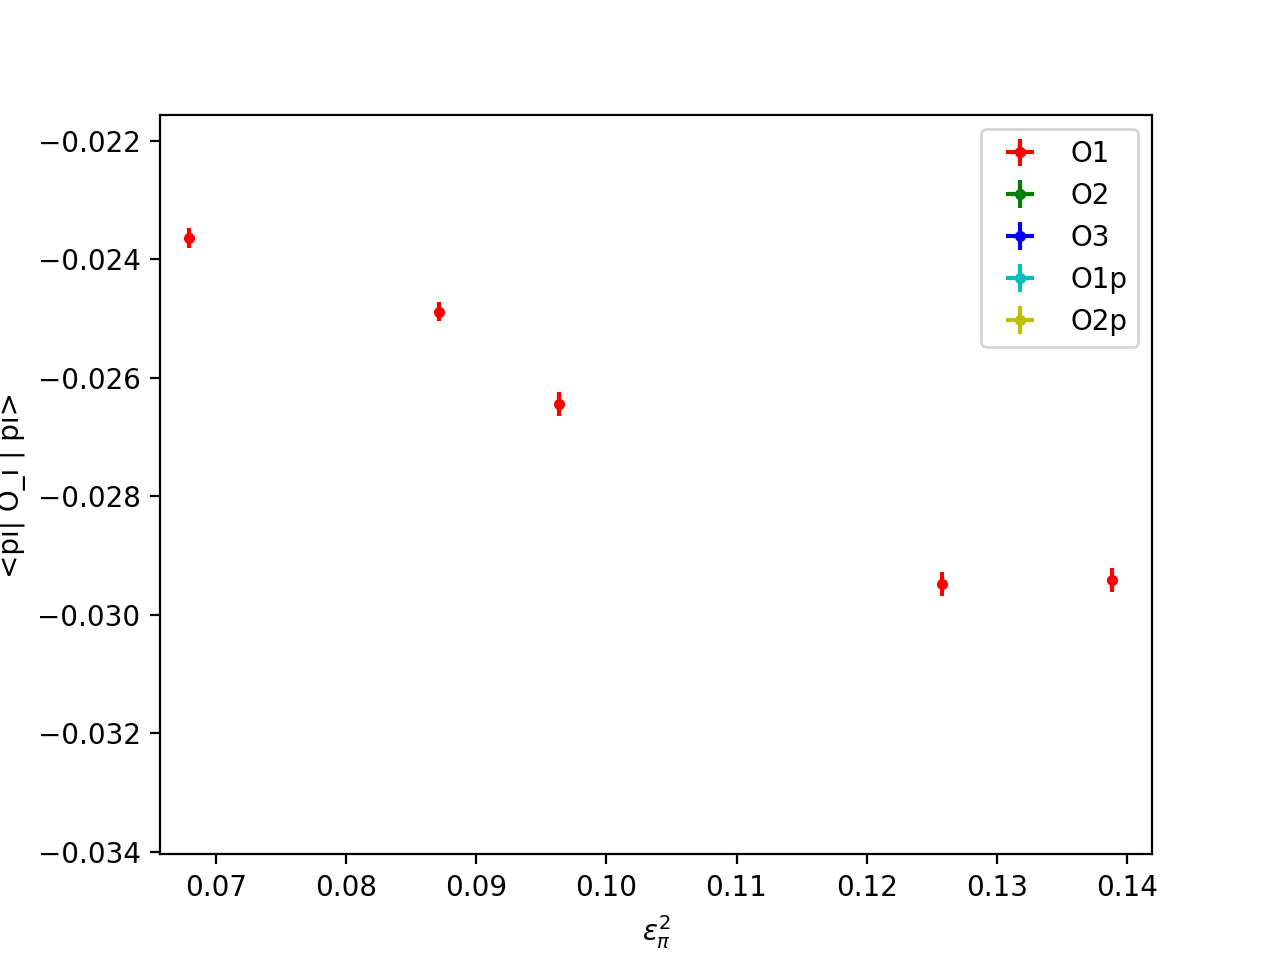

In [5]:
# Plot data points. This shouldn't match up with David's graph, that graph is plotting these points after subtracting the fit off
plt.figure()
for i in range(n_ops):
    plt.errorbar(eps_boot_μ, mat_boot_μ[:, i], xerr = eps_boot_σ, yerr = mat_boot_σ[:, i], fmt = '.', c = colors[i], label = labels[i])
plt.xlabel('$\epsilon_\pi^2$')
plt.ylabel('<pi| O_i | pi>')
plt.legend()
# plt.xlim((0, 0.16))
# plt.ylim((-0.08, 0.02))
plt.show()

In [6]:
def f0(m, L):
    f0 = 0
    for n1, n2, n3 in itertools.product(range(L), repeat = 3):
        if n1 == 0 and n2 == 0 and n3 == 0:
            continue
        n = np.sqrt(float(n1) ** 2 + float(n2) ** 2 + float(n3) ** 2)
        f0 += -2 * kn(0, m * L * n)
    return f0
def f1(m, L):
    f1 = 0
    for n1, n2, n3 in itertools.product(range(L), repeat = 3):
        if n1 == 0 and n2 == 0 and n3 == 0:
            continue
        n = np.sqrt(float(n1) ** 2 + float(n2) ** 2 + float(n3) ** 2)
        f1 += 4 * kn(1, m * L * n) / (m * L * n)
    return f0

In [7]:
# Define functional fit forms for the operators